In [ ]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

In [ ]:
DIR = r"C:\Temp\ML_Fruad_Files"
DIR_PROTOCOL = r"C:\Temp\ML_Fruad_Files\Protocol"
DIR_Neighborhood = r"C:\Temp\ML_Fruad_Files\Neighborhood_Clusters"

In [ ]:
# creating folders
folder_path = Path(DIR_PROTOCOL)
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
#!pip install geopandas

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

In [ ]:
#!pip install gdown

In [ ]:
import gdown

In [ ]:
# google dive address - so anyone could download the data
file_id = '18Jf8qyYuCXa9kVyQ94A0HqJ75lL5YrVq'  #   ה-ID
url = f'https://drive.google.com/uc?id={file_id}'

# download
gdown.download(url, f'{DIR}\Transactions_Customers_DC_2019.csv', quiet=False)

# reading data
df = pd.read_csv(f'{DIR}\Transactions_Customers_DC_2019.csv')

Downloading...
From: https://drive.google.com/uc?id=18Jf8qyYuCXa9kVyQ94A0HqJ75lL5YrVq
To: C:\Temp\ML_Fruad_Files\Transactions_Customers_DC_2019.csv
100%|██████████| 9.28M/9.28M [00:00<00:00, 10.4MB/s]


In [ ]:
df_backup = df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29210 entries, 0 to 29209
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ssn         29210 non-null  object 
 1   cc_num      29210 non-null  float64
 2   first       29210 non-null  object 
 3   last        29210 non-null  object 
 4   gender      29210 non-null  object 
 5   street      29210 non-null  object 
 6   city        29210 non-null  object 
 7   state       29210 non-null  object 
 8   zip         29210 non-null  int64  
 9   lat         29210 non-null  float64
 10  long        29210 non-null  float64
 11  city_pop    29210 non-null  int64  
 12  job         29210 non-null  object 
 13  dob         29210 non-null  object 
 14  acct_num    29210 non-null  float64
 15  profile     29210 non-null  object 
 16  trans_num   29210 non-null  object 
 17  trans_date  29210 non-null  object 
 18  trans_time  29210 non-null  object 
 19  unix_time   29210 non-nul

In [ ]:
df['ssn']=df['ssn'].astype('string') # US ID number
df['zip'] = df['zip'].astype('category') # zip code
drop_cols = ['trans_num'] # Unique transaction identifier
df = df.drop(columns=drop_cols)

## gender column

In [ ]:
#check
df['gender'].nunique() #2
df['gender'].value_counts() #M    15416, F    13794
df['gender'].isna().sum() #0

np.int64(0)

In [ ]:
#change column type
df['gender']=df['gender'].astype('category')

## street column
create new column - street_type for narrowing categories to 3 options

APT - apartment

SUITE - office/office unit

OTHER - usually a private house or an entire building

**An important note**

*In my test, there are no streets with these names in the real world. That means the data is fake (probably for work purposes).*

In [ ]:
#df['street'].nunique() #37
#df['street'].value_counts()
df['street'].isna().sum() #0

np.int64(0)

In [ ]:
df['street']=df['street'].astype('string')

In [ ]:
df['street_type'] = df['street'].apply(
    lambda x: 'APT' if 'APT' in str(x).upper()
    else 'SUITE' if 'SUITE' in str(x).upper()
    else 'OTHER'
)
df['street_type']=df['street_type'].astype('category')

In [ ]:
#df['street_type'].nunique() #3
#df['street_type'].value_counts() # OTHER    13461, SUITE     9825, APT       5924
#df['street_type'].isna().sum() #0

In [ ]:
#drop the column
if 'street' in df:
    df = df.drop(columns=['street'])

## Create distance & neighborhood columns - new features

In [ ]:
# Create a folder and missing parent folders
from pathlib import Path
folder_path = Path(DIR_Neighborhood)
folder_path.mkdir(parents=True, exist_ok=True)

In [ ]:
# i download file from website:  https://opendata.dc.gov/datasets/neighborhood-clusters/explore
# for creating new feature neighborhood
# i upload the file into google drive
file_id = '1yammht3SOwcvw5DPbQpoRfeovJJbupsP'  #   ה-ID
folder_url = 'https://drive.google.com/drive/folders/1yammht3SOwcvw5DPbQpoRfeovJJbupsP'

# download all files in folder
#!gdown --folder {folder_url} --quiet
!gdown --folder {folder_url} -O {DIR_Neighborhood} --quiet

### Creating coordinates from the file

In [ ]:
# creating coordinates from the file
# read file i download
# using geopandas
path = rf"{DIR_Neighborhood}\Neighborhood_Clusters.shp"
gdf_neighborhood = gpd.read_file(path)
gdf_neighborhood = gdf_neighborhood.to_crs("EPSG:4326") # Conversion to the same ESPG
# show first rows
#print(gdf_neighborhood.head())

In [ ]:
#gdf_neighborhood.columns

In [ ]:
#gdf_neighborhood[['NAME', 'NBH_NAMES']].head(10)

### creating coordinates from df data
### for customer

In [ ]:
# creating coordinates from df data
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['long'], df['lat']),
    crs="EPSG:4326"  # This is standard geographic coordinates (WGS84)
)

In [ ]:
#gdf['geometry'].plot()

In [ ]:
#print(gdf.crs)
#print(gdf_neighborhood.crs)

In [ ]:
#gdf.columns

Consolidating data by coordinate points

---
At a point where there is no match between the points, the value NAN will appear.

In [ ]:
joined = gpd.sjoin(
    gdf,
    gdf_neighborhood[['NAME', 'NBH_NAMES', 'geometry', 'SHAPEAREA']],  # relevant columns
    how='left',  # Keeping all rows of df_fraud
    predicate='within'  # Checking if the point is inside the polygon
)

In [ ]:
#len(joined)

In [ ]:
#joined.head(5)

In [ ]:
#Checking for missing values
#joined.isna().sum() #0

In [ ]:
# If there are duplicates (a point appears in several polygons), we will only keep the largest polygon.
#joined_sorted = joined.sort_values('SHAPEAREA', ascending=False)
#joined_unique = joined_sorted.groupby(joined_sorted.index).first().reset_index(drop=True)


### Creating new columns for customer :
cust_cluster - the neighborhood cluster number,

cust_neighborhood - the neighborhoods names in the location - could be greether then 1

num_neighborhoods - the number of neighborhoods according cust_neighborhood

In [ ]:
# Saving the data in the new columns in df
df['cust_cluster'] = (
    joined['NAME']
    .str.lower()          # Convert to lowercase ("cluster 40")
    .str.replace('cluster ', '', regex=False) # Replacement: Removing "cluster"
    .str.strip()          # Removing unnecessary spaces from the edges (if any)
    .astype('category')          # 4. Conversion to an integer
)
df['cust_neighborhood'] = joined['NBH_NAMES'].astype('string')

# Create a numeric column for the number of neighborhoods that are on the same border
df['num_neighborhoods'] = df['cust_neighborhood'].fillna('').str.count(',') + 1
df['num_neighborhoods'] = df['num_neighborhoods'].astype(int)

In [ ]:
df[['cust_neighborhood','num_neighborhoods']]

,cust_neighborhood,num_neighborhoods
0,Walter Reed,1
1,Walter Reed,1
2,Walter Reed,1
3,"North Michigan Park, Michigan Park, University...",3
4,"North Michigan Park, Michigan Park, University...",3
...,...,...
29205,"Capitol Hill, Lincoln Park",2
29206,"Capitol Hill, Lincoln Park",2
29207,"Capitol Hill, Lincoln Park",2
29208,"Capitol Hill, Lincoln Park",2


In [ ]:
df[df['is_fraud'] == 1]['cust_neighborhood'].value_counts()

cust_neighborhood
North Michigan Park, Michigan Park, University Heights                                      29
Brightwood Park, Crestwood, Petworth                                                        27
Capitol Hill, Lincoln Park                                                                  27
Kalorama Heights, Adams Morgan, Lanier Heights                                              24
Capitol View, Marshall Heights, Benning Heights                                             21
Congress Heights, Bellevue, Washington Highlands                                            21
Friendship Heights, American University Park, Tenleytown                                    21
Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View                                  19
Walter Reed                                                                                  9
Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point                  9
Shaw, Logan Circle              

In [ ]:
#df['cust_neighborhood'].nunique() #15
#df['cust_neighborhood'].value_counts() # Brightwood Park, Crestwood, Petworth
#df['cust_neighborhood'].isna().sum() #0

### creating coordinates from df data
### for marchent

In [ ]:
# create GeoDataFrame for merchant
gdf_merch = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['merch_long'], df['merch_lat']),
    crs="EPSG:4326"  # This is standard geographic coordinates (WGS84)
)

In [ ]:
#print(gdf_merch.crs)
#print(gdf_neighborhood.crs)

In [ ]:
joined_merch = gpd.sjoin(
    gdf_merch,
    gdf_neighborhood[['NAME', 'NBH_NAMES', 'geometry', 'SHAPEAREA']],  # Only the relevant fields
    how='left',
    predicate='within'
)

In [ ]:
# Checking for missing values
joined_merch['NBH_NAMES'].isna().sum() # 29074
# can see that there are 29074 missing values.
# That is, 29074 places are not in the range of the data we have from the collection.
# from the test I conducted, the locations are outside of Washington
# There are only 136 merchants inside Washington.
# Since the ratio is very large between the 2 groups, there is no significance in adding a new feature for this information

np.int64(29074)

### create distance column from customer to merchant

In [ ]:
# create distance column from customer to merchant
#!pip install geopy
from geopy.distance import geodesic

# function that calculate distance column from customer to merchant
def distance_merchant_customer(row):
    merch_coords = (row['merch_lat'], row['merch_long'])
    cust_coords = (row['lat'], row['long'])
    return geodesic(merch_coords, cust_coords).km

# create new column
df['distance_merch_cust'] = joined_merch.apply(distance_merchant_customer, axis=1)

# check
#print(df[['merch_lat', 'merch_long', 'lat', 'long', 'distance_merch_cust']].head())



### show the distribution of customer neighborhoods in the state of DC and Washington

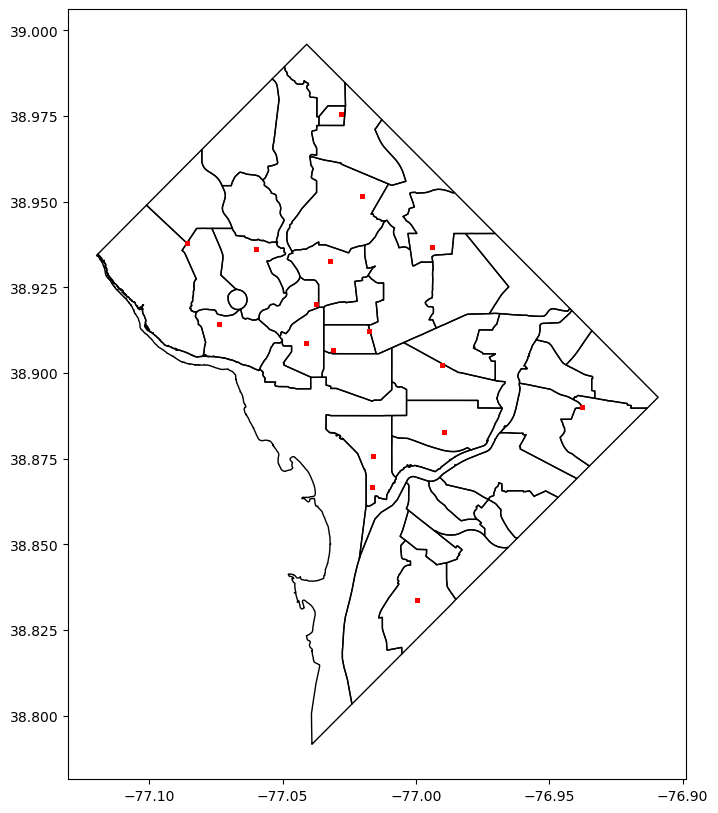

In [ ]:
import matplotlib.pyplot as plt

# neighborhoods
gdf_neighborhood.plot(facecolor='none', edgecolor='black', figsize=(10,10))

# customer location (in red)
gdf.plot(ax=plt.gca(), color='red', markersize=5)

plt.show()

### show the Number of customers in each cluster

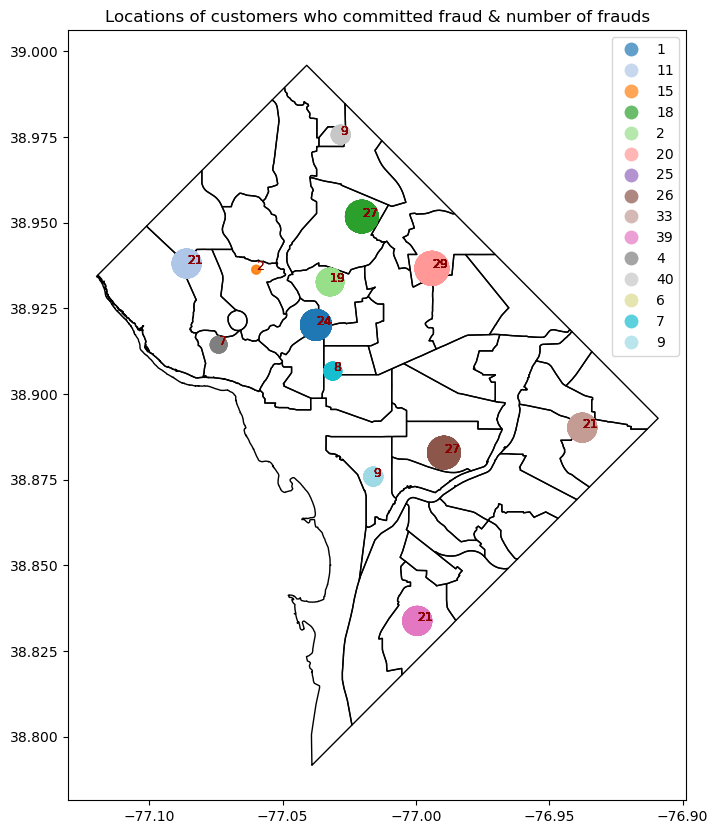

In [ ]:

fraud_counts = df[df['is_fraud'] == 1].groupby('cust_cluster', observed=False).size().reset_index(name='fraud_count')

df_fraud = df.merge(fraud_counts, on='cust_cluster', how='inner')
df_fraud = df_fraud[df_fraud['is_fraud'] == 1]  # only fraud

gdf_fraud = gpd.GeoDataFrame(
    df_fraud,
    geometry=gpd.points_from_xy(df_fraud['long'], df_fraud['lat']),
    crs="EPSG:4326"  # This is standard geographic coordinates (WGS84)
)

fig, ax = plt.subplots(figsize=(10,10))

# Painting neighborhoods
gdf_neighborhood.plot(ax=ax, facecolor='none', edgecolor='black')

# Fraud points drawing with size according to fraud amount
gdf_fraud.plot(ax=ax,
                column='cust_cluster',     # painting by Cluster
                cmap='tab20',              # different colors
                markersize=gdf_fraud['fraud_count'] * 20,
                legend=True,
                alpha=0.7)

# Writing the number of scams next to each point
for x, y, txt in zip(gdf_fraud.geometry.x, gdf_fraud.geometry.y, gdf_fraud['fraud_count']):
    ax.text(x, y, str(txt), fontsize=9, color='darkred')

plt.title("Locations of customers who committed fraud & number of frauds")
plt.show()


### Displaying the neighborhoods of customers involved in fraud

In [ ]:
df[df['is_fraud'] == 1]['cust_neighborhood'].value_counts()

cust_neighborhood
North Michigan Park, Michigan Park, University Heights                                      29
Brightwood Park, Crestwood, Petworth                                                        27
Capitol Hill, Lincoln Park                                                                  27
Kalorama Heights, Adams Morgan, Lanier Heights                                              24
Capitol View, Marshall Heights, Benning Heights                                             21
Congress Heights, Bellevue, Washington Highlands                                            21
Friendship Heights, American University Park, Tenleytown                                    21
Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View                                  19
Walter Reed                                                                                  9
Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point                  9
Shaw, Logan Circle              

In [ ]:
# after i get number of possible neighborhood for customer location, i can drop cust_neighborhood column
if 'cust_neighborhood' in df:
    df = df.drop(columns=['cust_neighborhood'])

## city column

In [ ]:
df['city'].nunique() #1
df['city'].value_counts() # Washington    29210
df['city'].isna().sum() #0

np.int64(0)

In [ ]:
# A column containing only one value - I removed the column
if 'city' in df:
    df = df.drop(columns={'city'})

## state column

In [ ]:
df['state'].nunique() #1
df['state'].value_counts() # DC    29210
df['state'].isna().sum() #0

np.int64(0)

In [ ]:
# A column containing only one value - I removed the column
if 'state' in df:
    df = df.drop(columns={'state'})

## job column
Creating new columns :

job_category , is_Risk Manager_Job



In [ ]:
#df['job'].nunique() #35
df['job'].value_counts()
#df['job'].isna().sum() #0

job
Tree surgeon                                                 1862
Clinical molecular geneticist                                1826
Community arts worker                                        1813
Quality manager                                              1485
Civil Service fast streamer                                  1480
Investment banker, operational                               1466
Hydrogeologist                                               1429
Technical brewer                                             1123
Exhibitions officer, museum/gallery                          1079
Health visitor                                               1060
Landscape architect                                          1059
Museum/gallery curator                                        773
Naval architect                                               752
Psychotherapist, child                                        751
Administrator, Civil Service                                  750
Artist

In [ ]:
# The Mapping Dictionary
occupation_mapping = {
    # 1. health and nursing
    'Clinical scientist, histocompatibility and immunogenetics': 'Health_&_Care',
    'Therapist, nutritional': 'Health_&_Care',
    'Biomedical engineer': 'Health_&_Care',
    'Learning disability nurse': 'Health_&_Care',
    'Clinical molecular geneticist': 'Health_&_Care',
    'Health visitor': 'Health_&_Care',
    'Psychiatric nurse': 'Health_&_Care',

    # 2. Finance and Risk Management
    'Pension scheme manager': 'Finance_&_Risk',
    'Banker': 'Finance_&_Risk',
    'Investment banker, operational': 'Finance_&_Risk',
    'Risk manager': 'Finance_&_Risk',

    # 3. Retail and Marketing
    'Sales promotion account executive': 'Retail_&_Marketing',
    'Retail manager': 'Retail_&_Marketing',
    'Merchandiser, retail': 'Retail_&_Marketing',

    # 4. General administration and operations
    'Administrator, Civil Service': 'Govt_&_Admin',
    'Civil Service fast streamer': 'Govt_&_Admin',
    'Quality manager': 'Govt_&_Admin',
    'Office manager': 'Govt_&_Admin',

    # 5. Arts, Culture and Leisure
    'Community arts worker': 'Arts_Culture_&_Leisure',
    'Producer, radio': 'Arts_Culture_&_Leisure',
    'Museum/gallery curator': 'Arts_Culture_&_Leisure',
    'Exhibitions officer, museum/gallery': 'Arts_Culture_&_Leisure',
    'Artist': 'Arts_Culture_&_Leisure',

    # 6. Land, Environment and Agriculture
    'Landscape architect': 'Land_&_Environment',
    'Amenity horticulturist': 'Land_&_Environment',
    'Agricultural consultant': 'Land_&_Environment',
    'Tree surgeon': 'Land_&_Environment',
    'Conservation officer, historic buildings': 'Land_&_Environment',

    # 7. Experts and technicians (Tail Group)
    'Lexicographer': 'Specialist_&_Technical',
    'Technical brewer': 'Specialist_&_Technical',
    'Psychotherapist, child': 'Specialist_&_Technical',
    'Database administrator': 'Specialist_&_Technical',
    'TEFL teacher': 'Specialist_&_Technical',
    'Naval architect': 'Specialist_&_Technical',
    'Hydrogeologist': 'Specialist_&_Technical'
}

# Create a category column according to the mapping
df['job_category'] = df['job'].map(occupation_mapping).fillna('Other')
df['job_category']=df['job_category'].astype('category')


In [ ]:
df['job_category'].value_counts()

job_category
Specialist_&_Technical    6204
Arts_Culture_&_Leisure    5156
Land_&_Environment        5090
Health_&_Care             5026
Govt_&_Admin              4101
Finance_&_Risk            2192
Retail_&_Marketing        1441
Name: count, dtype: int64

In [ ]:
# want to see the rare jobs
df['job']=df['job'].astype('string')
job_stats = (
    df.groupby('job').agg(fraudCnt = ('is_fraud', 'sum'), cnt = ('is_fraud', 'count')      )
      .assign(fraud_rate = lambda x: x['fraudCnt'] / x['cnt'] * 100)
      .sort_values('fraud_rate', ascending=False)
)

job_stats.head(20)

# in this example we see that job 'Risk manager' is with 100% fraud and this is the reason
# i add new column is_Risk Manager_Job



,fraudCnt,cnt,fraud_rate
job,,,
Risk manager,9,9,100.000000
Office manager,11,386,2.849741
"Therapist, nutritional",8,358,2.234637
Amenity horticulturist,15,705,2.127660
"Producer, radio",12,745,1.610738
"Psychotherapist, child",12,751,1.597870
Database administrator,11,703,1.564723
Agricultural consultant,11,723,1.521438
TEFL teacher,11,731,1.504788


In [ ]:
df['is_Risk Manager_Job'] = (df['job'].str.lower() == 'risk manager').astype('bool')

In [ ]:
df.loc[df['job'] == 'Risk manager', ['is_Risk Manager_Job', 'job']] #check

,is_Risk Manager_Job,job
21274,True,Risk manager
21275,True,Risk manager
21276,True,Risk manager
21277,True,Risk manager
21278,True,Risk manager
21279,True,Risk manager
21280,True,Risk manager
21544,True,Risk manager
21545,True,Risk manager


In [ ]:
if 'job' in df:
    df = df.drop(columns=['job'])

## profile column

This column contains information broken down by age group, gender, and type of residential area.

In [ ]:
#df['profile'].nunique() #4
#df['profile'].value_counts() #adults_2550_male_urban.json , adults_50up_female_urban.json ,adults_2550_female_urban.json ,adults_50up_male_urban.json
df['profile'].isna().sum() #0

np.int64(0)

In [ ]:
df['profile']=df['profile'].astype('string') # פרופיל

In [ ]:
df[['profile_group', 'profile_age_group', 'profile_gender', 'profile_region']] = df['profile'].str.replace('.json', '', regex=False).str.split('_', expand=True)

In [ ]:
if 'profile_gender' in df:
    df['profile_gender'].value_counts() #male - 15416 , female - 13794
#df['gender'].value_counts()#M - 15416, F - 13794

In [ ]:
# Check for mismatched rows
if 'profile_gender' in df:
    differences = df[df['profile_gender'].map( {'male': 'M', 'female': 'F'} ) != df['gender']]

In [ ]:
len(differences)

0

In [ ]:
# There is no difference between the columns - the information is stable
# The profile_gender column is not needed, so i removed it
if 'profile_gender' in df:
    df = df.drop(columns={'profile_gender'})

In [ ]:
# All lines belong to the same group - adults
# so i removed it
if 'profile_group' in df:
    df['profile_group'].nunique() #1
    df['profile_group'].value_counts() # adults
    df = df.drop(columns={'profile_group'})

In [ ]:
#if 'profile_age_group' in df:
df['profile_age_group'].nunique() #2
df['profile_age_group'].value_counts() # 2550 - 18340, 50up - 10870
df['profile_age_group']=df['profile_age_group'].astype('category')

In [ ]:
#  All lines belong to the same group - urban
# so i removed it
if 'profile_region' in df:
    df['profile_region'].nunique() #1
    df['profile_region'].value_counts() # urban
    df = df.drop(columns={'profile_region'})

In [ ]:
# I analyzed this column fully and saw that it was not needed because some of the data appears in other columns.
# some of the data is unreliable, so we have no use for it
# so i removed it
if 'profile' in df:
    df = df.drop(columns={'profile'})

## category column
There are 14 different categories for purchases

I have grouped them into the following 4 categories:

'online', 'retail_pos', 'leisure', 'household'

In [ ]:
df['category'].nunique() #14
df['category'].value_counts()
#df['category'].isna().sum() #0

category
grocery_pos       5726
gas_transport     4925
shopping_pos      4787
shopping_net      3969
misc_pos          3922
misc_net          2625
grocery_net       2516
entertainment      715
personal_care       10
home                 7
travel               3
health_fitness       2
kids_pets            2
food_dining          1
Name: count, dtype: int64

In [ ]:
# Total Frauds ÷ Total Transactions by Category
#fraud_percent = df.groupby('category')['is_fraud'].sum() / df.groupby('category')['is_fraud'].count() * 100
#print(fraud_percent.sort_values(ascending=False).round(2))

In [ ]:
fraud_stats = df.groupby('category')['is_fraud'].agg(['sum', 'count'])

# Fraud percentage creation
fraud_stats['fraud_percent'] = fraud_stats['sum'] / fraud_stats['count'] * 100

# Sort by fraud percentage from highest to lowest
print(fraud_stats.sort_values(by='fraud_percent', ascending=False).round(2))


                sum  count  fraud_percent
category                                 
food_dining       1      1         100.00
health_fitness    2      2         100.00
home              7      7         100.00
kids_pets         2      2         100.00
personal_care    10     10         100.00
travel            3      3         100.00
shopping_net     51   3969           1.28
misc_net         28   2625           1.07
entertainment     6    715           0.84
grocery_pos      48   5726           0.84
shopping_pos     29   4787           0.61
gas_transport    28   4925           0.57
misc_pos          7   3922           0.18
grocery_net       2   2516           0.08


In [ ]:
df['category'] = df['category'].str.lower()
df['category_group'] = np.select(
    [
        df['category'].isin(['shopping_net', 'misc_net', 'grocery_net']),
        df['category'].isin(['shopping_pos', 'grocery_pos', 'misc_pos']),
        df['category'].isin(['entertainment']),
        df['category'].isin(['gas_transport']),
        df['category'].isin(['home', 'kids_pets', 'food_dining', 'personal_care', 'travel', 'health_fitness'])
    ],
    ['online', 'retail_pos', 'Entertainment', 'Transport', 'Lifestyle(rare)'],
    default='other'
)
df['category_group']=df['category_group'].astype('category') # קטגוריה

In [ ]:
#df['category'] = df['category'].astype('category')
if 'category' in df:
    df = df.drop(columns=['category'])
df['category_group'].nunique() #4
#df['category_group'].value_counts()
#df['category_group'].isna().sum() #0


5

## dob column - date of birth

In [ ]:
df['dob'] = pd.to_datetime(df['dob'])

In [ ]:
df['dob'].nunique() #37
#df['dob'].value_counts() #
#df['dob'].isna().sum() #0
df['dob'].min() # 1972
#df['dob'].max() # 9/10/1994

Timestamp('1936-08-28 00:00:00')

## trans_date, trans_time columns

Merging the fields into one trans_datetime field

Creating new fields from the merged data: month, day of the week, time category of the day

Creating a new field for the time category: morning, afternoon, evening, night

And creating an age field by combining the time field + date of birth

Since the fields we created are identical in meaning to the unix_time field ,
I decided to remove it

In [ ]:
# Merge columns into one time column
df['trans_datetime'] = pd.to_datetime(df['trans_date'] + ' ' + df['trans_time'])
df['trans_datetime'] = pd.to_datetime(df['trans_datetime'])
if 'trans_date' in df:
    df = df.drop(columns='trans_date')
if 'trans_time' in df:
    df = df.drop(columns='trans_time')
if 'unix_time' in df:
    df = df.drop(columns='unix_time')

In [ ]:
# Create a month column
df['trans_month'] = df['trans_datetime'].dt.month
df['trans_month']=df['trans_month'].astype('category')

In [ ]:
# Create a day of the week column
# Monday=0, Sunday=6
df['trans_day_of_week_num'] = df['trans_datetime'].dt.dayofweek
df['trans_day_of_week_num']=df['trans_day_of_week_num'].astype('category')

In [ ]:
df['trans_hour'] = df['trans_datetime'].dt.hour
df['trans_hour']=df['trans_hour'].astype('int')

In [ ]:
# Creating categories by parts of the day
df['trans_hour_category'] = pd.cut(
    df['trans_datetime'].dt.hour,
    bins=[0, 6, 12, 18, 24],   # The limits of the hours
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)
df['trans_hour_category']=df['trans_hour_category'].astype('category') # Occupation Category

In [ ]:
# Create a customer age column at the time of transaction
df['age'] = df['trans_datetime'].dt.year - df['dob'].dt.year
df['age']=df['age'].astype('int')

In [ ]:
df['age'].nunique() #26 different ages

26

In [ ]:
df['age'].min()

21

In [ ]:
df['age'].max()

83

In [ ]:
# Check whether there is an age that is less than 25 years and also appears in a group that is greater than/equal to 25 to 50
df[(df['age'] < 25) & (df['profile_age_group'] == '2550')].count()

ssn                      2618
cc_num                   2618
first                    2618
last                     2618
gender                   2618
zip                      2618
lat                      2618
long                     2618
city_pop                 2618
dob                      2618
acct_num                 2618
amt                      2618
is_fraud                 2618
merchant                 2618
merch_lat                2618
merch_long               2618
street_type              2618
cust_cluster             2618
num_neighborhoods        2618
distance_merch_cust      2618
job_category             2618
is_Risk Manager_Job      2618
profile_age_group        2618
category_group           2618
trans_datetime           2618
trans_month              2618
trans_day_of_week_num    2618
trans_hour               2618
trans_hour_category      2618
age                      2618
dtype: int64

In [ ]:
# It can be seen that it is not worth relying on a column profile_age_group
# so i removed it
if 'profile_age_group' in df:
    df = df.drop(columns='profile_age_group')

In [ ]:
# Create a new column that divides the ages
# Defining age ranges

#bins = [20, 30, 40, 50, 60, 85]
bins = [20, 50, 60, 70, 85]

# categories names
#labels = ['21-30', '31-40', '41-50', '51-60', '61-85']
labels = ['21-50', '51-60', '61-70', '71-85']

# create age_group column
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)


In [ ]:
df['age_group']=df['age_group'].astype('category')

In [ ]:
df.groupby('age')['is_fraud'].sum()

age
21     9
24     0
25    21
28    10
29     0
31     0
34     9
36    15
38    18
41    18
42    18
44     0
46     0
47     9
48    17
49     0
50     0
52    11
53     8
59    11
60     0
68     0
70    20
75    11
76    12
83     7
Name: is_fraud, dtype: int64

In [ ]:
# This columns are no longer needed
# so i removed them
if 'trans_datetime' in df:
    df = df.drop(columns=['trans_datetime'])

if 'dob' in df:
    df = df.drop(columns=['dob'])

if 'age' in df:
    df = df.drop(columns=['age'])

## merchant column
In all data lines, the merchant starts with the word fraud

I replaced the word with an empty string so that the column only contains the vendor name.

I also cleaned up special characters in the name

In [ ]:
#df['merchant'] = df['merchant'].str.replace('fraud_', '', regex=True).str.lower()
# cleaning
def clean_name(name):
    # If the input is not a string or empty/only spaces, return NaN
    if not isinstance(name, str) or name.strip() == '':
        return pd.NA

    # Removing prefix 'fraud_' if present
    name = re.sub(r'^fraud_', '', name)

    # Replacing commas or hyphens with a space
    #name = re.sub(r'[,-]', ' ', name)
    # Replacing commas, hyphens, or non-letter/number special characters with a space
    name = re.sub(r"[^a-zA-Z0-9\s]", " ", name)

    # Replace multiple spaces with a single space
    name = re.sub(r'\s+', ' ', name)

    # Removing unnecessary spaces at the beginning and end
    name = name.strip().lower()

    return name

df['merchant'] = df['merchant'].apply(clean_name)

In [ ]:
df['merchant']=df['merchant'].astype('string')

In [ ]:
#df.groupby('merchant')['is_fraud'].sum().sort_values(ascending=False)

In [ ]:
df.groupby('merchant').agg(
          fraudCnt = ('is_fraud', lambda x: (x == 1).sum()),
          cnt = ('is_fraud', 'count')
      ).sort_values(by='fraudCnt', ascending=False)


,fraudCnt,cnt
merchant,,
huel hammes and witting,4,116
schoen kuphal and nitzsche,3,117
zboncak rowe and murazik,3,74
padberg welch,3,134
barrows plc,3,113
...,...,...
jenkins hauck and friesen,0,113
jast mcdermott,0,89
jaskolski vandervort,0,50


In [ ]:
merchant_counts = df['merchant'].value_counts()
print(merchant_counts.describe())

count        423.0
mean     69.054374
std      35.420151
min            1.0
25%           48.0
50%           76.0
75%           95.0
max          157.0
Name: count, dtype: Float64


In [ ]:
def merchant_group(freq):
    if freq <= 48:
        return 'Very_Low'
    elif 49 <= freq <= 76:
        return 'Low'
    elif 77 <= freq <= 95:
        return 'Medium'
    else: #96 <= freq <= 157:
        return 'High'

In [ ]:
if 'merchant' in df:
    # Create a frequency column for traders
    df['merchant_freq'] = df['merchant'].map(df['merchant'].value_counts())

    # Create the group by frequency
    df['merchant_grouped'] = df['merchant_freq'].apply(merchant_group)

    # check
    #df[['merchant','merchant_freq','merchant_grouped']].head(10)
    #df['merchant_grouped'].isna().sum()

    df = df.drop(columns=['merchant', 'merchant_freq'])
    df['merchant_grouped'] = df['merchant_grouped'].astype('category')

## city_pop column

In [ ]:
if 'city_pop' in df:
    df['city_pop'].nunique() #1
    df['city_pop'].value_counts() #601723    29210
    df['city_pop'].isna().sum() #0

In [ ]:
# It has only one value.
# so i removed it
if 'city_pop' in df:
    df = df.drop(columns=['city_pop'])

## first, last columns

In [ ]:
df['last'] = df['last'].apply(clean_name)
df['first'] = df['first'].apply(clean_name)
df['first']=df['first'].astype('string') # first name
df['last']=df['last'].astype('string') # last name
df = df.drop(columns=['first', 'last'])

## acct_num column - no issue

In [ ]:
#df['acct_num'].nunique() #37
#df['acct_num'].value_counts()
#df['acct_num'].isna().sum() #0

In [ ]:
# 1. Calculating acct_num_cnt using transform
# The command counts the unique values in acct_num in each acct_num group

#df['acct_num_cnt'] = df.groupby('acct_num')['acct_num'].transform('count')

#df.head(5)
#df.info()

## ssn, acct_num, cc_num columns

In [ ]:
# Checking how many cards and accounts each SSN has (ssn = customer id)
df_card_account_counts = df.groupby('ssn').agg(
    unique_cards=('cc_num', 'nunique'),
    unique_accounts=('acct_num', 'nunique'),
    total_transactions=('ssn', 'count')
).reset_index()

In [ ]:
df_multiple = df_card_account_counts[
    (df_card_account_counts['unique_cards'] > 1) |
    (df_card_account_counts['unique_accounts'] > 1)
]
print(len(df_multiple))
# conclusion
# Each customer has one card and one account.
# so this columns have the same meaning
# and therefore i decided to drop cc_num column and ssn column(for security reasons)
if 'cc_num' in df:
    df = df.drop(columns=['cc_num'])
if 'ssn' in df:
    df = df.drop(columns=['ssn'])

df['acct_num'] = df['acct_num'].astype('category')

0


## zip, cust_cluster  columns

In [ ]:
#df['cust_cluster'].nunique() #15
#df['cust_cluster'].value_counts() # Cluster 18
#df['cust_cluster'].isna().sum() #0

In [ ]:
#print("Unique zip:", df['zip'].nunique()) #17
#print("Unique CLUSTER:", df['cust_cluster'].nunique()) #15

In [ ]:
#df[(df['cust_cluster'] == 1) & (df['is_fraud'] == 1)]['acct_num']

In [ ]:
# Fraud percentage per region
df.groupby('cust_cluster', observed=False)['is_fraud'].mean().sort_values(ascending=False) * 100
# conclusion:
#Cluster 1 is a very sensitive area for fraud → customer behavior there is more suspicious.
#Clusters 25 and 6 show no fraud, so they are safe areas.
#The location of the customer Cluster is a very important feature for a predictive model.


cust_cluster
1     3.361345
11    1.428571
40    1.227831
26    1.062574
4     0.979021
20    0.893132
33    0.808314
7     0.744879
2     0.741030
39    0.652579
18    0.603622
9     0.346287
15    0.092507
25    0.000000
6     0.000000
Name: is_fraud, dtype: float64

In [ ]:
#df[df['is_fraud']==1]['cust_cluster'].value_counts()
df.groupby(['cust_cluster'], observed=False)['is_fraud'].agg(count='count',
    sum='sum',
    fraud_percent=lambda x: x.sum() / x.count() * 100).reset_index()


,cust_cluster,count,sum,fraud_percent
0,1,714,24,3.361345
1,11,1470,21,1.428571
2,15,2162,2,0.092507
3,18,4473,27,0.603622
4,2,2564,19,0.741030
5,20,3247,29,0.893132
6,25,375,0,0.000000
7,26,2541,27,1.062574
8,33,2598,21,0.808314
9,39,3218,21,0.652579


In [ ]:
# see number of cust_cluster in zip
# seems that the columns represnt the same
# i decided to remove zip
if 'zip' in df:
    zip_cluster_table = df.groupby('zip', observed=False)['cust_cluster'].first().reset_index()
    print(zip_cluster_table)
    df = df.drop(columns=['zip'])

      zip cust_cluster
0   20001            7
1   20002           25
2   20003           26
3   20005            7
4   20007            4
5   20008           15
6   20009            1
7   20010            2
8   20011           18
9   20012           40
10  20016           11
11  20017           20
12  20019           33
13  20024            9
14  20032           39
15  20036            6
16  20319            9


## save to file

In [ ]:
df.to_pickle(f'{DIR}\mrg_df_after_prep_stage1.pkl')

In [ ]:
df.to_csv(f'{DIR}\Transactions_Customers_DC_2019_FlatFile.csv', index=False)